# Exponential families, entropy

Reference:
- Jordan: "The exponential family: basics": https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/other-readings/chapter8.pdf

- Jordan: "The exponential family: conjugate priors": https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/other-readings/chapter9.pdf

## Most common probability distributions are particular cases of the exponential family

### Examples
- Gaussian / normal
- Exponential
- Poisson
- von Mises
- multinomial
- Bernoulli
- Veta

## Appealing properties

- convexity
- sufficient statistics

**Minimizing the KL divergence to the empirical distribution is equivalent to maximizing the likelihood.** Result from Ch 8, Jordan..

# Information entropy

In [16]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

## Example: loaded dice

Suppose you have information that the long-run average roll of an unfair die is $\mu$ (say 2.0) instead of the 3.5 you would expect from a fair die.

What probability distribution would you assign to the faces of the die?

Let's try out some numbers:

In [40]:
x = np.linspace(1, 6, num=6)
x

array([ 1.,  2.,  3.,  4.,  5.,  6.])

In [224]:
p0 = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0])

In [226]:
p0

array([ 0.2,  0.2,  0.2,  0.2,  0.2,  0. ])

We need to have $\sum p(x_i) = 1$ for it to be a probability distribution.

We also need the expectation $E(X) = \sum p(x_i) x_i = \mu = 2.0$

In [227]:
np.sum(p0)

1.0

In [228]:
np.average(x, weights=p0)

3.0

So the constraint that the average is 2.0 is not yet satisfied.

### Exercise: try tweaking the numbers for $p$ so the average is 2.0

#### Hint: this function can help. Try tweaking the first parameter so the return value is 2.0

In [76]:
def expectation(p_unnormalized, sample_space):
    """
    The expectation E X = \sum x_i p(x_i) of a discrete
    random variable X on the given sample space after
    normalizing p so it sums to 1.
    
    Parameters
    ----------
    
    """
    p = p_unnormalized / np.sum(p_unnormalized)
    return np.average(x, weights=p)

The model $p$ that satisfies this constraint is not unique.

Here are two examples:

In [229]:
p1 = np.array([10, 5, 1, 1, 1, 1])
p2 = np.array([40, 2, 3, 5, 1, 6])

In [230]:
expectation(p1, x)

2.0000000000000004

In [231]:
expectation(p2, x)

2.0

What do these look like?

In [232]:
import seaborn as sns

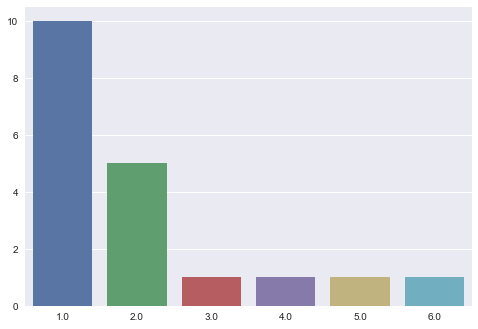

In [233]:
sns.barplot(x, p1)

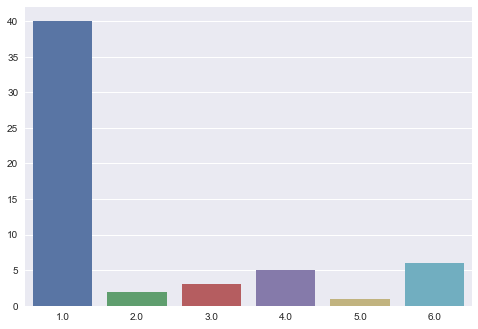

In [234]:
sns.barplot(x, p2)

Which of these is the most plausible? Why?


The first one is "flatter". It is less surprising, less informative. It contains less "information" (defined shortly).

## Example: guessing the word

Case 1: You are told the word starts "xys". What's the word?

According to http://www.thefreedictionary.com/words-that-start-with-xys, there is only one 4-letter word: xyst (a portico in Greek architecture)

Case 2: You are told the word starts "non". What's the word?

You have much less information now.

**Definition:** the information contained in an observation is $H = -\log(p) = \log(1 / p)$

### Aside: frequencies in English

In [140]:
url = 'https://github.com/dwyl/english-words/blob/master/words_alpha.txt?raw=true'

In [194]:
import requests
import toolz as tz

In [142]:
words = requests.get(url).text.split()

In [200]:
# Group by 3-letter prefixes:
groups = tz.groupby(lambda word: word[:3], words)

In [216]:
groups['xys']

['xyst',
 'xyster',
 'xysters',
 'xysti',
 'xystoi',
 'xystos',
 'xysts',
 'xystum',
 'xystus']

In [201]:
def peek(d, n=5):
    return dict(random.sample(d.items(), n))

In [203]:
peek(groups)

{'agt': ['agt', 'agtbasic'],
 'ghy': ['ghyll', 'ghylls'],
 'na': ['na'],
 'nco': ['nco'],
 'sv': ['sv']}

In [204]:
freqs = tz.valmap(len, groups)

In [205]:
# Most common 5 3-letter prefixes:
sorted(freqs, key=freqs.get, reverse=True)[:5]

['non', 'pre', 'ove', 'pro', 'con']

In [196]:
len(groups['non'])

7479

### Back to the modelling problem ...

Bernoulli and Laplace derived results about probabilities assuming the "principle of insufficient reason" (https://en.wikipedia.org/wiki/Principle_of_indifference): if $n$ possibilities (mutually exclusive and exhaustive) are indistinguishable except for their names, then each possibility should be assigned a probability equal to $1 / n$.

This is the simplest non-informative prior in Bayesian settings.

## Principle of maximum entropy

The principle of maximum entropy is a generalization of this when we do have some information. It states that, subject to all prior information we do know, we should choose the **flattest**, least informative model (i.e. making the fewest additional assumptions), in the sense of maximizing the **Shannon information entropy** $H(p)$.

For a discrete, countable sample space $\mathcal{X}$, the Shannon information entropy is defined as:
$$H(p) = - \sum_{i=1}^n p(x) \log p(x)$$

i.e. the average information (defined above) in an observation.

In [235]:
from scipy.stats import entropy

In [236]:
entropy(p1)

1.3090157953711272

In [237]:
entropy(p2)

1.0424362543394536

### What is the maxent prior for $p(\mathbf{x}) = p(x_1), ..., p(x_6)$? 

We can use `scipy.optimize` to minimize this as a function of 5 variables (6 minus one for the normalizing constraint):

In [19]:
n = 6  # 6-sided die
μ = 2.0  # prior information: long-term average roll

In [222]:
import scipy.optimize as opt

In [273]:
p0 = np.ones(6) / 6

In [274]:
p0

array([ 0.16666667,  0.16666667,  0.16666667,  0.16666667,  0.16666667,
        0.16666667])

In [248]:
# Each probability p(x_i) is bounded between 0 and 1
bounds = [[0, 1]] * 6

In [249]:
from math import isclose
isclose(2.000000001, 2)

True

In [258]:
constraints = {'type': 'eq',
                'fun': lambda p: isclose(2, expectation(p, x))}

In [275]:
def negentropy(p):
    return -entropy(p)

In [278]:
opt.minimize(negentropy,
             p0,
             bounds=bounds,
             constraints=constraints)

     fun: -1.791759469228055
     jac: array([  1.49011612e-08,   1.49011612e-08,   1.49011612e-08,
         2.98023224e-08,   1.49011612e-08,   2.98023224e-08,
         0.00000000e+00])
 message: 'Singular matrix C in LSQ subproblem'
    nfev: 8
     nit: 1
    njev: 1
  status: 6
 success: False
       x: array([ 0.16666667,  0.16666667,  0.16666667,  0.16666667,  0.16666667,
        0.16666667])

This has failed. We need a better optimization method.

### From here below requires OpenOpt

In [323]:
import openopt

In [325]:
# c(x) <= 0 constraints
c = [lambda p_i: -p_i]*6

In [326]:
μ

2

In [327]:
# general equality constraints
# h(x) = 0
# We want h(x) = expectation(p) - μ = 0
def h(p):
    return expectation(p, x) - μ

In [328]:
problem = openopt.NLP(negentropy,
                      p0,
                      lb=[0]*6,
                      ub=[1]*6,
                      c=c,
                      h=h)

In [330]:
problem.solve('ralg', plot=True)


------------------------- OpenOpt 0.5625 -------------------------
problem: unnamed   type: NLP    goal: minimum
solver: ralg


ModuleNotFoundError: No module named 'FuncDesigner'

In [21]:
def func(r):
    return (n-μ)*r**(n+1) + (μ-n-1)*r**n + μ*r - μ + 1
 
initial_guess = 0.5
r = fsolve(func, initial_guess)

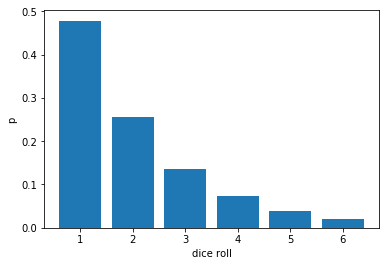

In [20]:
index = np.zeros([n])
p = np.zeros([n])
 
for i in range(1,n+1):
    index[i-1] = i
    p[i-1] = ((1-r)/(1-r**n))*r**(i-1)

plt.bar(index, p)
plt.ylabel('p')
plt.xlabel('dice roll')
plt.show()

## We will see better ways to fit exponential models next